<a href="https://colab.research.google.com/github/frianlh/WebMining-Project/blob/main/Case_Study_4_Group_F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> **Studi Kasus 4: Korelasi dan Regresi**

## **Grup F**
1. Amanda Sarah Ivana (1906375814)
2. Divina Fatriandira (1906299465)
2. Fria Nurul Hidayat (1906299484)
3. Galih Nur Kantaatmaja (2006571141)
4. Rosyda Hanavania (1906299566)
5. Timothy Devan Chandra (1906375726)

# Pendahuluan

* Bangunan perlu banyak energi untuk melakukan berbagai kegiatan: *heating, cooling, steam*, dan penggunaan listrik lainnya. Penggunaan energi tersebut memerlukan biaya yang tinggi dan menghasilkan emisi yang banyak.
* Hadirlah *improvement* berupa pemberian <u> retrofit</u> pada bangunan-bangunan untuk meningkatkan efisiensi bangunan untuk mengurangi biaya dan emisi.
* Sebagai informasi, pemilik gedung melakukan pembayaran berdasarkan perbedaan antara konsumsi energi riil mereka dan apa yang akan mereka gunakan tanpa retrofit.
  * Untuk hal ini, dibutuhkan dua nilai: nilai konsumsi energi dengan retrofit, dan nilai konsumsi energi tanpa retrofit
  * Nilai konsumsi energi dengan retrofit didapat dari data yang ada
  * Tetapi, tidak ada data historik yang berisi nilai konsumsi energi tanpa retrofit
* Untuk mencari nilai konsumsi energi tanpa retrofit, dibutuhkan sebuah model pengestimasi. Model ini akan dibuat dengan mempertimbangkan faktor prediktor apa saja yang layak untuk dimasukkan.
  * Akan dikembangkan model akurat penggunaan energi meteran bangunan di areaberikut: air dingin (*chilled water*), listrik (*electric*), air panas (*hot water*), dan meteran uap (*steam meters*)
* Setelah model didapat, akan dilihat keefektifan dari retrofit yang diberikan.

# Tujuan Bisnis
Dengan perkiraan yang baik dari model penghitungan energi ini, (dan pengestimasian keefektifan *improvement* untuk penggunaan energi), investor skala besar dan lembaga keuangan akan lebih cenderung berinvestasi di bidang ini untuk memungkinkan kemajuan dalam efisiensi pembangunan.

# Modul dan Packages yang Digunakan

In [ ]:
# Import Modules
import warnings; warnings.simplefilter('ignore')
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np
import missingno as msno

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.api as sm, scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# Penginputan Data

Data merupakan data "rata-rata" penggunaan energi listrik dari berbagai gedung.

In [ ]:
# Import Data Set from GitHub
file_ = 'data/Ashrae_Energy_Mean.csv'
try: # Running Locally
    df = pd.read_csv(file_, low_memory = False, encoding = 'utf8')
except: # Running in Google Colab
    !mkdir data
    !wget -P data/ https://raw.githubusercontent.com/taudataid/eLearning/master/data/Ashrae_Energy_Mean.csv
    df = pd.read_csv(file_, low_memory = False, encoding = 'utf8')

In [ ]:
# Data Size
N, P = df.shape
print('baris = ', N, ', Kolom (jumlah variabel) = ', P)

# Variable Type
print("Tipe Variabel df = ", type(df))

baris =  1413 , Kolom (jumlah variabel) =  12
Tipe Variabel df =  <class 'pandas.core.frame.DataFrame'>


**Catatan**:
Data terdiri dari 1413 baris dan 12 kolom.

In [ ]:
# Show The First Five Data
df.head(10)

,meter_reading,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,237.749127,Education,7432,2008.0,NaN,22.744816,2.998727,17.379328,1.240589,1017.949437,152.521015,3.391472
1,118.553743,Education,2720,2004.0,NaN,22.744816,2.998727,17.379328,1.240589,1017.949437,152.521015,3.391472
2,23.626500,Education,5376,1991.0,NaN,22.744816,2.998727,17.379328,1.240589,1017.949437,152.521015,3.391472
3,382.736016,Education,23685,2002.0,NaN,22.744816,2.998727,17.379328,1.240589,1017.949437,152.521015,3.391472
4,1579.174237,Education,116607,1975.0,NaN,22.744816,2.998727,17.379328,1.240589,1017.949437,152.521015,3.391472
5,28.963481,Education,8000,2000.0,NaN,22.744816,2.998727,17.379328,1.240589,1017.949437,152.521015,3.391472
6,104.080095,Lodging/residential,27926,1981.0,NaN,22.744816,2.998727,17.379328,1.240589,1017.949437,152.521015,3.391472
7,569.244417,Education,121074,1989.0,NaN,22.744816,2.998727,17.379328,1.240589,1017.949437,152.521015,3.391472
8,417.394827,Education,60809,2003.0,NaN,22.744816,2.998727,17.379328,1.240589,1017.949437,152.521015,3.391472
9,118.129516,Office,27000,2010.0,NaN,22.744816,2.998727,17.379328,1.240589,1017.949437,152.521015,3.391472


## Informasi Variabel

Data:
* `meter_reading`: konsumsi energi (kWh)
* `primary_use`: indikator dari kategori primer dari aktivitas gedung
* `square_feet`: luas area (gross) dari gedung
* `year_built`: tahun dibangunnya gedung
* `floor_count`: jumlah lantai dalam gedung
* `air_temperature`: suhu udara (Celsius)
* `cloud_coverage`: porsi langit yang tertutup awan (Oktas)
* `dew_temperature`: temperatur saat air harus didinginkan untuk tersaturasi dengan uap air (Celsius)
* `precip_depth_1_hr`: (Milimeters)
* `sea_level_pressure`: (Milibar/hectopascals)
* `wind_direction`: Arah gerak angin (0-360 arah kompas)
* `wind_speed`: Kecepatan angin (m/s)

In [ ]:
# Show The Last Five Data
df.tail(10)

,meter_reading,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
1403,190.983473,Education,56497,1957.0,NaN,9.079138,1.092101,4.512823,3.381837,1017.192111,186.648787,3.619547
1404,254.019257,Lodging/residential,150294,1987.0,NaN,9.079138,1.092101,4.512823,3.381837,1017.192111,186.648787,3.619547
1405,293.638837,Education,30143,1951.0,NaN,9.079138,1.092101,4.512823,3.381837,1017.192111,186.648787,3.619547
1406,88.691376,Public services,99541,1993.0,NaN,9.079138,1.092101,4.512823,3.381837,1017.192111,186.648787,3.619547
1407,89.441291,Education,40311,1913.0,NaN,9.079138,1.092101,4.512823,3.381837,1017.192111,186.648787,3.619547
1408,7.484137,Entertainment/public assembly,19619,1914.0,NaN,9.079138,1.092101,4.512823,3.381837,1017.192111,186.648787,3.619547
1409,4.732815,Education,4298,NaN,NaN,9.079138,1.092101,4.512823,3.381837,1017.192111,186.648787,3.619547
1410,7.211347,Entertainment/public assembly,11265,1997.0,NaN,9.079138,1.092101,4.512823,3.381837,1017.192111,186.648787,3.619547
1411,187.117994,Lodging/residential,29775,2001.0,NaN,9.079138,1.092101,4.512823,3.381837,1017.192111,186.648787,3.619547
1412,3.338595,Office,92271,2001.0,NaN,9.079138,1.092101,4.512823,3.381837,1017.192111,186.648787,3.619547


In [ ]:
# Data Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1413 entries, 0 to 1412
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   meter_reading       1413 non-null   float64
 1   primary_use         1413 non-null   object 
 2   square_feet         1413 non-null   int64  
 3   year_built          663 non-null    float64
 4   floor_count         352 non-null    float64
 5   air_temperature     1413 non-null   float64
 6   cloud_coverage      1396 non-null   float64
 7   dew_temperature     1413 non-null   float64
 8   precip_depth_1_hr   1237 non-null   float64
 9   sea_level_pressure  1324 non-null   float64
 10  wind_direction      1413 non-null   float64
 11  wind_speed          1413 non-null   float64
dtypes: float64(10), int64(1), object(1)
memory usage: 132.6+ KB


**Catatan**: Dari informasi data di atas, kami melihat bahwa `primary_use` memiliki tipe data *object*, variabel tersebut seharusnya bertipe *categorical*. Perubahan tipe ini akan kami lakukan di tahap berikutnya.

Dapat dilihat juga bahwa jumlah data non-null pada variabel `year_built` dan `floor_count` jauh lebih sedikit dibanding variabel yang lain. Selanjutnya, kami akan menghitung jumlah baris yang merupakan Missing Value dari data



In [ ]:
print(df.isnull().sum())

meter_reading            0
primary_use              0
square_feet              0
year_built             750
floor_count           1061
air_temperature          0
cloud_coverage          17
dew_temperature          0
precip_depth_1_hr      176
sea_level_pressure      89
wind_direction           0
wind_speed               0
dtype: int64


**Catatan**: Terlihat benar bahwa `year_built` dan `floor_count` memiliki baris null yang besar, maka dari itu kami akan menghilangkan variabel tersebut.

In [ ]:
df.describe(include = 'all')

,meter_reading,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,1413.000000,1413,1413.000000,663.000000,352.000000,1413.000000,1396.000000,1413.000000,1237.000000,1324.000000,1413.000000,1413.000000
unique,NaN,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Education,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,185.383188,NaN,92204.792640,1968.170437,3.738636,15.697154,2.166618,8.259831,1.187860,1016.466990,175.351051,3.564617
std,374.899500,NaN,111412.340117,31.026539,3.336731,5.416736,1.461644,4.625295,1.478667,1.921973,24.921236,0.737746
min,0.000400,NaN,283.000000,1900.000000,1.000000,7.572136,0.059266,-0.304675,0.155325,1011.436563,123.388701,2.157103
25%,27.224943,NaN,22949.000000,1949.500000,1.000000,11.058629,0.665832,4.512823,0.775686,1016.404579,153.629430,3.100911
50%,74.933148,NaN,57673.000000,1970.000000,3.000000,15.204244,2.083712,8.285693,0.895980,1016.797495,184.295922,3.619547
75%,182.884848,NaN,115288.000000,1995.500000,5.000000,21.325261,2.998727,9.834399,1.033215,1017.949437,187.301104,3.905433


**Catatan**: Dari hasil Statistika Deskriptif di atas, dapat dilihat bahwa tidak terdapat Noise dalam data. Dapat dilihat juga skala dalam tiap variabel data berbeda-beda, maka dalam tahap selanjutnya kami akan mekonsiderasi untuk melakukan scaling pada data agar dapat memiliki skala yang sama.

# **PREPROCESSING DATA**

## Missing Value

In [ ]:
# Copy Data
df1 = df.copy()

In [ ]:
df1.drop(df1.iloc[:, 3:5], inplace = True, axis = 1)
df1.head()

,meter_reading,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,237.749127,Education,7432,22.744816,2.998727,17.379328,1.240589,1017.949437,152.521015,3.391472
1,118.553743,Education,2720,22.744816,2.998727,17.379328,1.240589,1017.949437,152.521015,3.391472
2,23.626500,Education,5376,22.744816,2.998727,17.379328,1.240589,1017.949437,152.521015,3.391472
3,382.736016,Education,23685,22.744816,2.998727,17.379328,1.240589,1017.949437,152.521015,3.391472
4,1579.174237,Education,116607,22.744816,2.998727,17.379328,1.240589,1017.949437,152.521015,3.391472


**Catatan**: Kami menghilangkan variabel `year_built` dan `floor_count` karena jumlah Missing Value dalam variabel tersebut besar (lebih dari 50%)
* `floor_count` memiliki missing value sebesar 75%
* `year_built` memiliki missing value sebanyak 53%

## Tipe Data

In [ ]:
# Type Data Correction
df1['primary_use'] = df1['primary_use'].astype('category')
# Unique values pada Variabel Menikah
df1['primary_use'].dtypes

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1413 entries, 0 to 1412
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   meter_reading       1413 non-null   float64 
 1   primary_use         1413 non-null   category
 2   square_feet         1413 non-null   int64   
 3   air_temperature     1413 non-null   float64 
 4   cloud_coverage      1396 non-null   float64 
 5   dew_temperature     1413 non-null   float64 
 6   precip_depth_1_hr   1237 non-null   float64 
 7   sea_level_pressure  1324 non-null   float64 
 8   wind_direction      1413 non-null   float64 
 9   wind_speed          1413 non-null   float64 
dtypes: category(1), float64(8), int64(1)
memory usage: 101.5 KB


**Catatan**: Kami mengubah tipe data `primary_use` dari *object* menjadi tipe *categorical*. Hal ini sesuai dengan Data Understanding dimana `primary_use` adalah indikator dari kategori primer dari aktivitas gedung, sehingga tipe data harusnya adalah Kategorik

## Duplikat

In [ ]:
# Duplicate Check
print(df1.duplicated().sum())

0


**Catatan**: Dapat dilihat bahwa data tidak memiliki baris yang duplikat.

## Pemisahan Variabel

In [ ]:
# Variable Selection
df_num = df1.select_dtypes(include = ('int64', 'float64'))
df_num.head()

,meter_reading,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,237.749127,7432,22.744816,2.998727,17.379328,1.240589,1017.949437,152.521015,3.391472
1,118.553743,2720,22.744816,2.998727,17.379328,1.240589,1017.949437,152.521015,3.391472
2,23.626500,5376,22.744816,2.998727,17.379328,1.240589,1017.949437,152.521015,3.391472
3,382.736016,23685,22.744816,2.998727,17.379328,1.240589,1017.949437,152.521015,3.391472
4,1579.174237,116607,22.744816,2.998727,17.379328,1.240589,1017.949437,152.521015,3.391472


In [ ]:
# Variable Selection
df_cat = df1.select_dtypes(include = ('category'))
df_cat.head()

,primary_use
0,Education
1,Education
2,Education
3,Education
4,Education


**Catatan**: Dari data terdapat dua jenis data, ada yang merupakan data numerik dan data yang kategorik. Maka dari itu, kami memisahkan kedua jenis data tersebut.
* Membentuk dataframe variabel numerik dengan memasukkan variabel dengan tipe ‘int64’ dan ‘float62’
* Membentuk dataframe variabel kategorik dengan memasukkan variabel dengan tipe ‘category’


## Missing Value

In [ ]:
# Copy Data
df2 = df1.copy()

In [ ]:
# Get Total Missing Values
print(df2.isnull().sum())

meter_reading           0
primary_use             0
square_feet             0
air_temperature         0
cloud_coverage         17
dew_temperature         0
precip_depth_1_hr     176
sea_level_pressure     89
wind_direction          0
wind_speed              0
dtype: int64


**Catatan**: Terlihat bahwa masih terdapat data Missing Value pada variabel `cloud_coverage`, `precip_depth_1_hr`, `sea_level_pressure`. Akan kami lihat posisi dari data Missing Value tersebut.
* `cloud_coverage` -> 17 baris -> 1% dari data
* `precip_depth_1_hr` -> 176 baris -> 12% data
* `sea_level_pressure` -> 89 bairs -> 6% data 


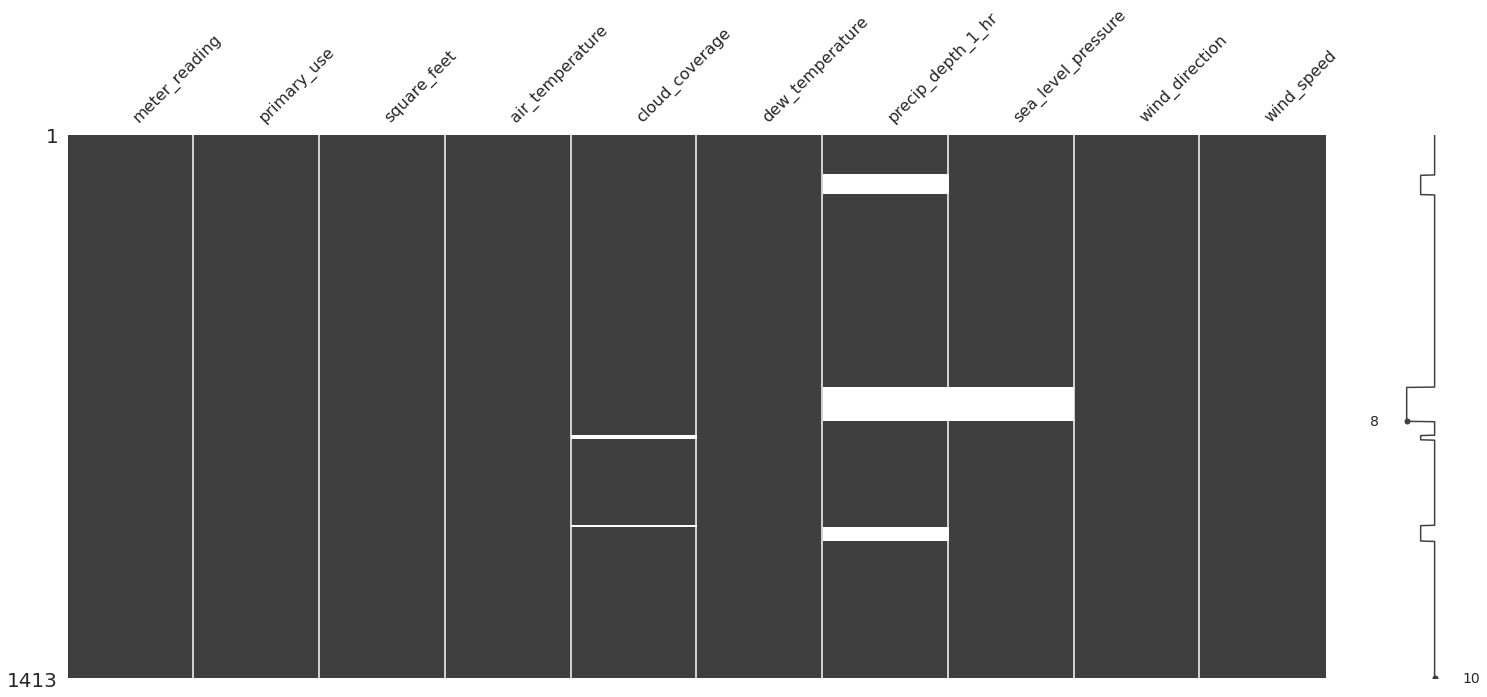

In [ ]:
# Gives positional information of the missing values
msno.matrix(df2)

**Catatan**: Dari plot Heatmap Missing Value, dapat dilihat letak missing value pada data.

Kami mengkonsiderasi untuk melakukan *drop* pada baris data yang memiliki Missing Value. Alasan kami melakukan *drop* alih-alih imputasi data adalah karena tujuan dari analisis ini membutuhkan data asli. Jika kami melakukan imputasi, khawatir nilai tersebut akan memengaruhi hasil.

In [ ]:
# Drop Missing Values
df2 = df2.dropna()
df2.shape

(1220, 10)

**Catatan**: Hasil data setelah melakukan *drop* pada tahap sebelumnya adalah menjadi 1220 baris dan 10 variabel

## Outlier

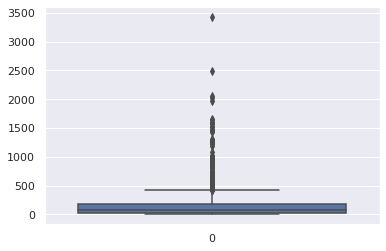

In [ ]:
# Detection Outlier in meter_reading
p = sns.boxplot(data = df2['meter_reading'])

**Catatan**: Pada boxplot dapat dilihat bahwa pada variabel `meter_reading` masih banyak terdapat outlier

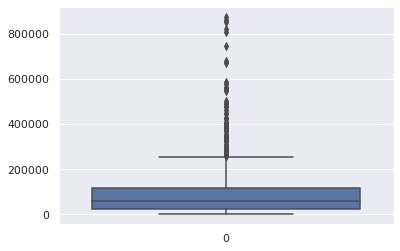

In [ ]:
# Detection Outlier in square_feet
p = sns.boxplot(data = df2['square_feet'])

**Catatan**: Pada boxplot dapat dilihat bahwa pada variabel `square_feet` banyak terdapat outlier

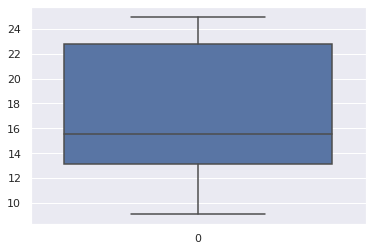

In [ ]:
# Detection Outlier in air_temperature
p = sns.boxplot(data = df2['air_temperature'])

**Catatan**: Pada boxplot dapat dilihat bahwa pada variabel `air_temperature` tidak terdapat outlier

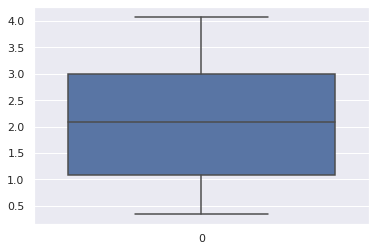

In [ ]:
# Detection Outlier in cloud_coverage
p = sns.boxplot(data = df2['cloud_coverage'])

**Catatan**: Pada boxplot dapat dilihat bahwa pada variabel `cloud_coverage` tidak terdapat outlier

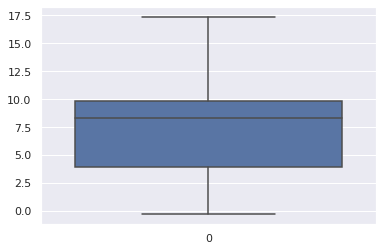

In [ ]:
# Detection Outlier in dew_temperature
p = sns.boxplot(data = df2['dew_temperature'])

**Catatan**: Pada boxplot dapat dilihat bahwa pada variabel `dew_temperature` tidak terdapat outlier

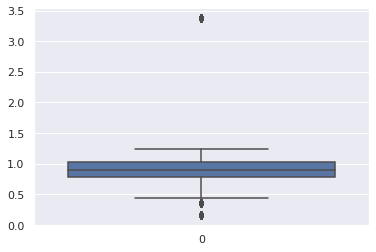

In [ ]:
# Detection Outlier in precip_depth_1_hr
p = sns.boxplot(data = df2['precip_depth_1_hr'])

**Catatan**: Pada boxplot dapat dilihat bahwa pada variabel `precip_depth_1_hr` masih terdapat sedikit outlier

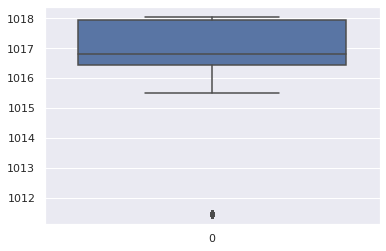

In [ ]:
# Detection Outlier in sea_level_pressure
p = sns.boxplot(data = df2['sea_level_pressure'])

**Catatan**: Pada boxplot dapat dilihat bahwa pada variabel `sea_level_pressure` terdapat 1 outlier


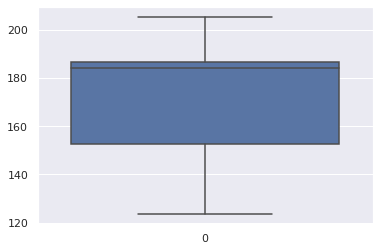

In [ ]:
# Detection Outlier in wind_direction
p = sns.boxplot(data = df2['wind_direction'])

**Catatan**: Pada boxplot dapat dilihat bahwa pada variabel `wind_direction` tidak terdapat outlier

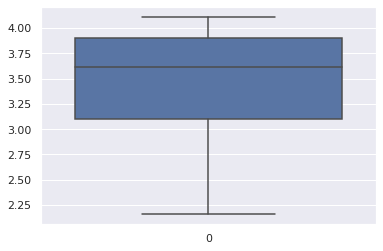

In [ ]:
# Detection Outlier in wind_speed
p = sns.boxplot(data = df2['wind_speed'])

**Catatan**: Pada boxplot dapat dilihat bahwa pada variabel `wind_speed` tidak terdapat outlier

## Handling Outlier

Pada boxplot2 di atas, kita ketahui bahwa masih terdapat outlier pada variabel-variabel tertentu. Namun, outlier tersebut tidak akan kami pisahkan karena data yang kita miliki merupakan data asli yang terdapat pada lapangan dan dapat memuat informasi penting.

Sebagai informasi pendukung, outlier banyak terdapat di variabel `meter_reading`, yang mana variabel tersebut adalah variabel target dari data. Hal tersebut juga memberikan kami alasan untuk tidak memisahkan outlier.

Sebagai perhatian, dengan tidak memisahkan outlier pada data maka akan memengaruhi hasil akhir analisis.

## Scaling Data menggunakan Normalization

Kami akan melakukan scaling data dengan menggunakan metode Normalization. Kami tidak menggunakan metode MinMax karena metode tersebut tidak robust terhadap outlier.

In [ ]:
# Normalization
df_num = df2.select_dtypes(include = ('int64', 'float64'))

df3 = preprocessing.normalize(df_num, axis=0)
df3 = pd.DataFrame(df3, columns = ['meter_reading', 'square_feet', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed'])
df3.head()

,meter_reading,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0.020124,0.001452,0.037555,0.032794,0.051074,0.026878,0.028668,0.02533,0.028137
1,0.010035,0.000531,0.037555,0.032794,0.051074,0.026878,0.028668,0.02533,0.028137
2,0.002000,0.001050,0.037555,0.032794,0.051074,0.026878,0.028668,0.02533,0.028137
3,0.032396,0.004627,0.037555,0.032794,0.051074,0.026878,0.028668,0.02533,0.028137
4,0.133667,0.022778,0.037555,0.032794,0.051074,0.026878,0.028668,0.02533,0.028137


In [ ]:
df_cat = df2.select_dtypes(include = ('category'))

df4 = df3.copy()
df4['primary_use'] = df_cat
df4.head()

**Catatan**: Kami memasukkan variabel `primary_use` dalam dataframe kami yang telah dilakukan Normalisasi data. Sehingga, df3 atau data yang kami gunakan mencakup seluruh variabel numerik maupun kategorik.

# **EXPLORATORY DATA ANALYSIS**

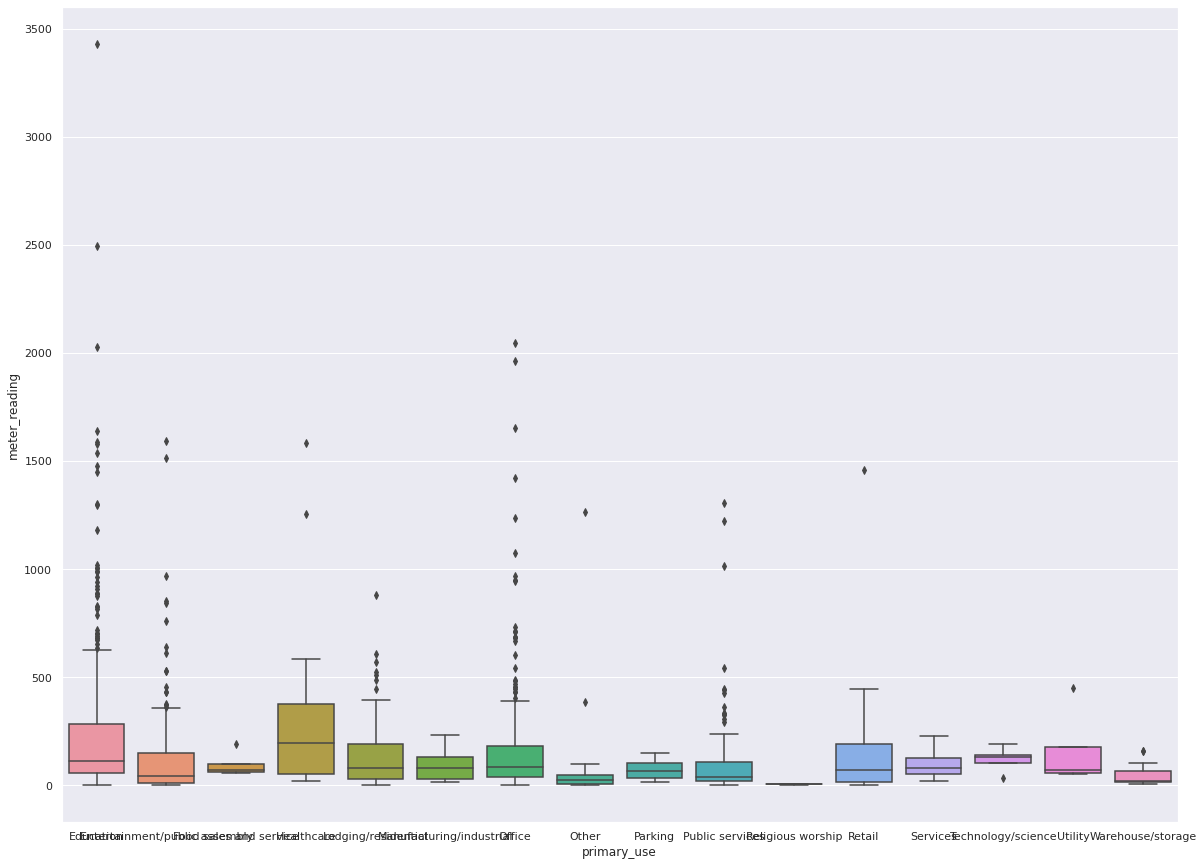

In [ ]:
plt.figure(figsize = (20, 15))
p = sns.boxplot(x = 'primary_use', y = 'meter_reading', data = df2)

**Catatan**: Terlihat dari plot diatas, dengan menggunakan parameter x sebagai `primary_use` dan parameter y sebagai `meter_reading`, terlihat bahwa terdapat outlier yang cukup banyak pada gedung yang digunakan sebagai sarana pendidikan dan memiliki outlier tertinggi. Sehingga dapat disimpulkan bahwa terdapat gedung dengan `primary_use` education yang menggunakan penggunaan energi yang sangat tinggi.

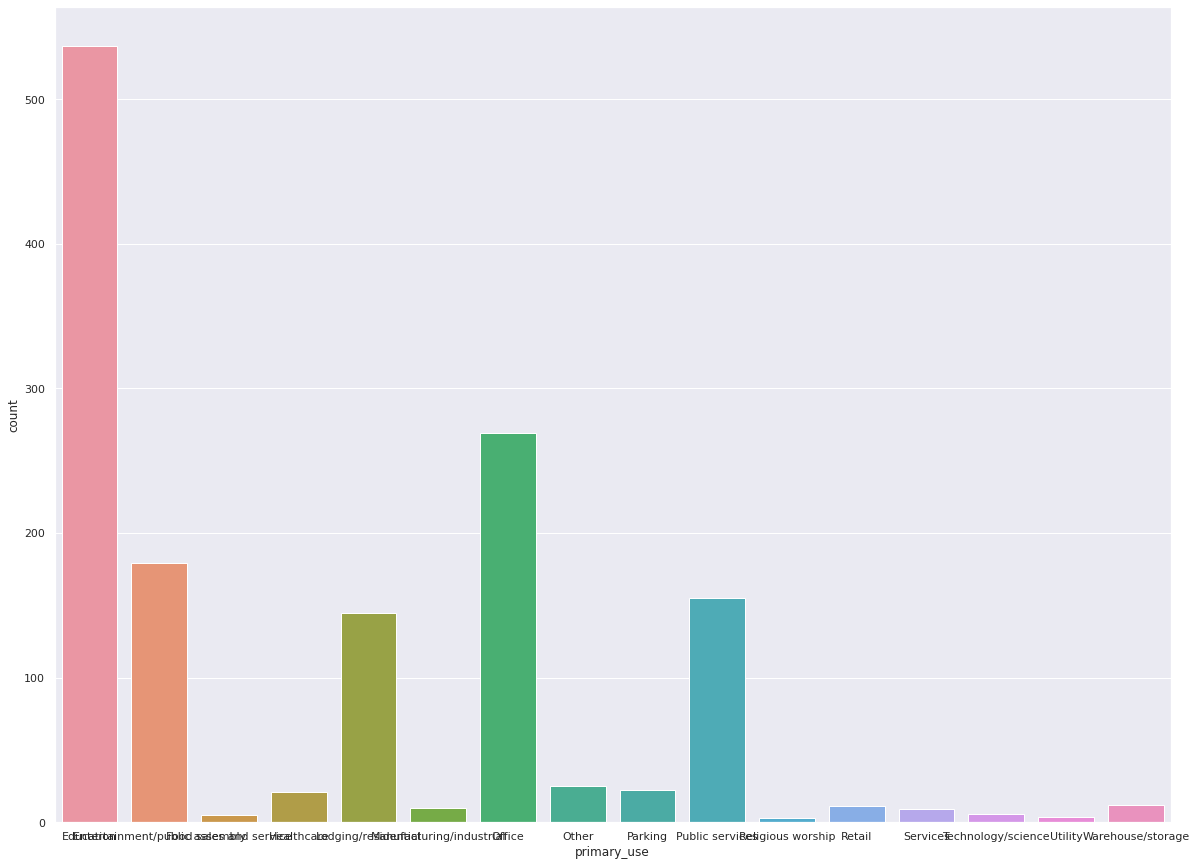

In [ ]:
plt.figure(figsize = (20, 15))
p = sns.countplot(x = 'primary_use', data = df2)

**Catatan**: Dari plot di atas, dengan menggunakan parameter x sebagai `primary_use`, terlihat bahwa jenis bangungan terbanyak adalah `primary_use` Education. Dengan nilai count yang lebih dari 400.

Untuk kategori `primary_use` yang cenderung sedikit, kami tidak melakukan penggabungan. Alasan kami adalah kami ingin melihat apakah dari kategori tersebut menghasilkan suatu informasi.

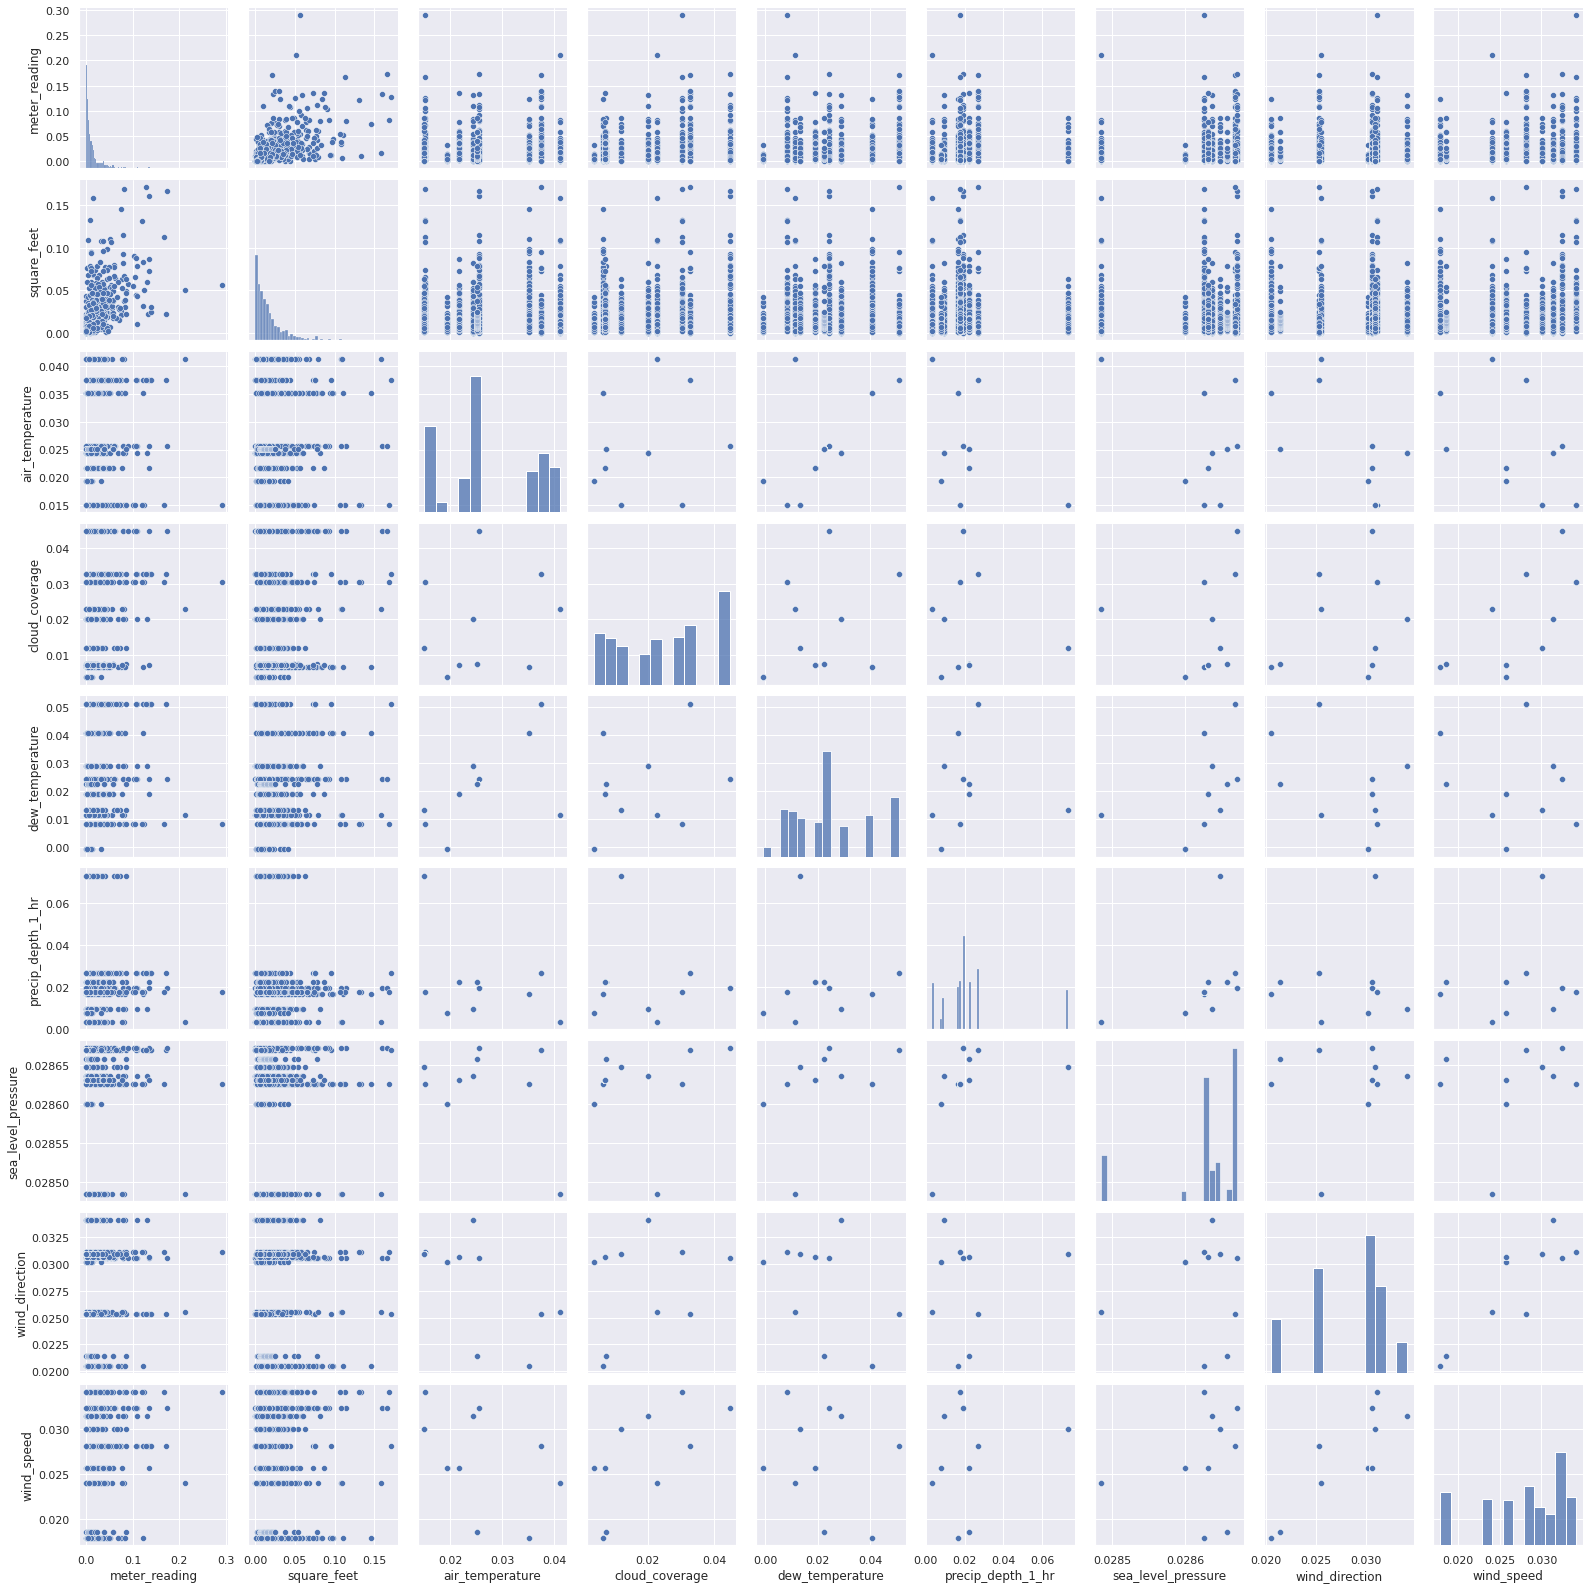

In [ ]:
p = sns.pairplot(df4)

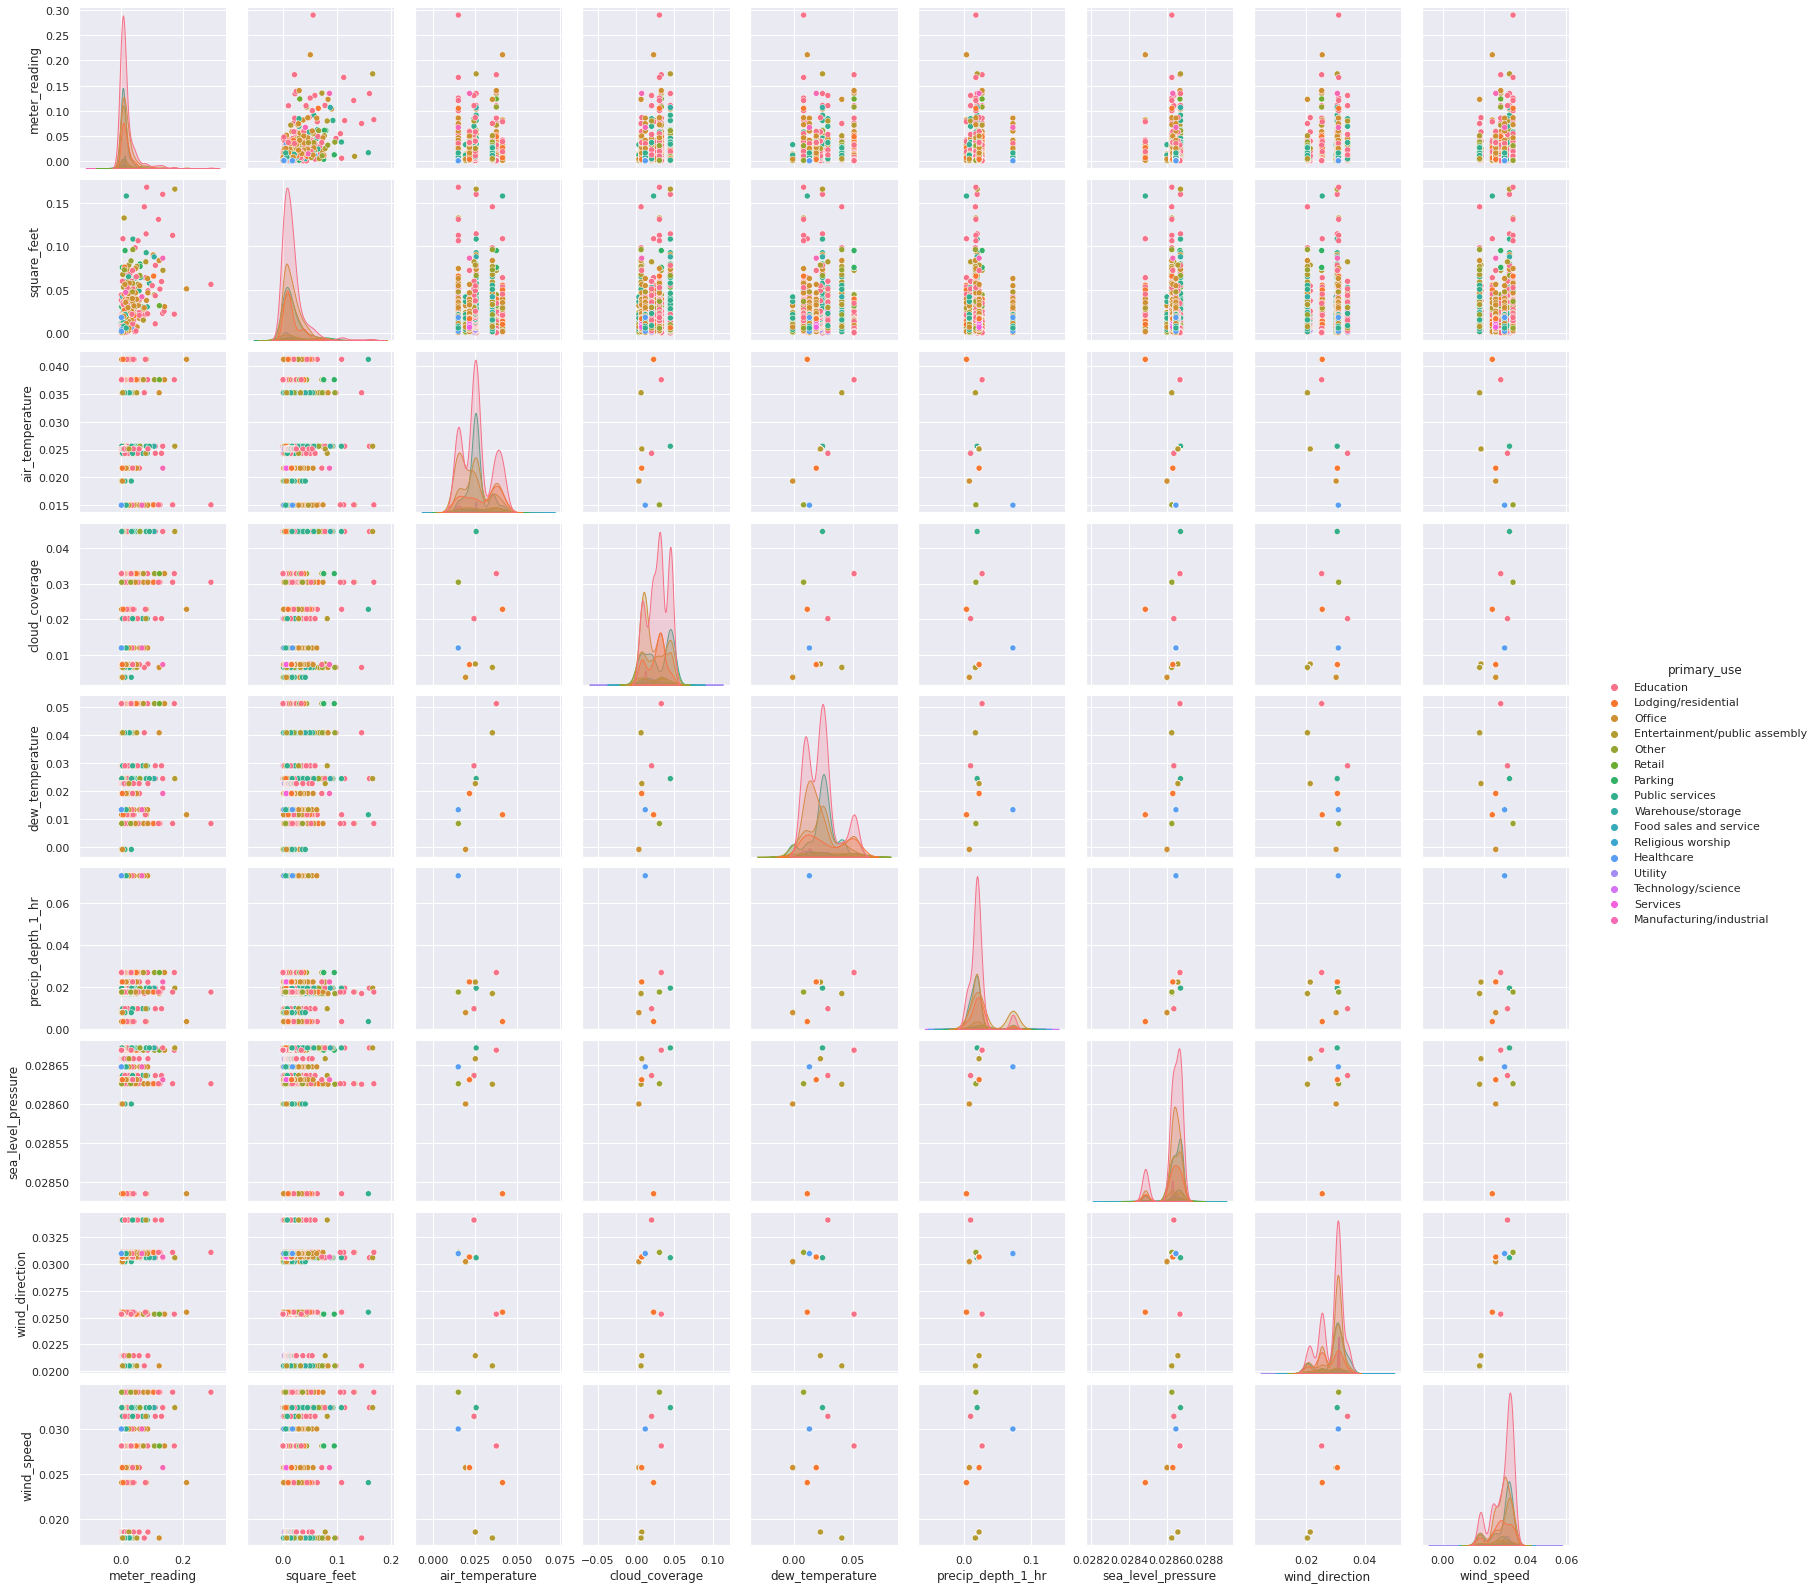

In [ ]:
# Plot Data
p = sns.pairplot(df4, hue = 'primary_use')

## Plot Korelasi

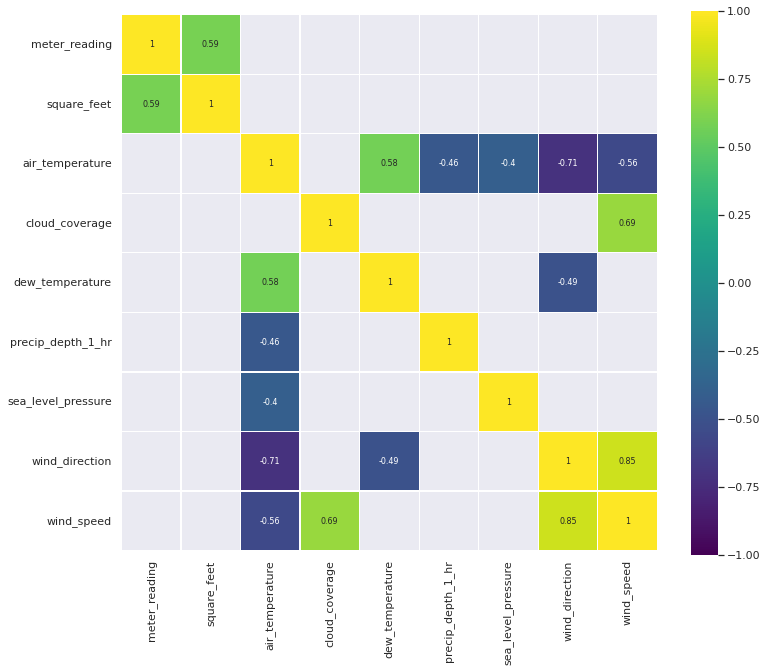

In [ ]:
# Correlation Plot
corr2 = df4.corr()
plt.figure(figsize = (12, 10))
sns.heatmap(corr2[(corr2 >= 0.5) | (corr2 <= -0.4)],
 cmap = 'viridis', vmax = 1.0, vmin = -1.0, linewidths = 0.1,
 annot = True, annot_kws = {"size": 8}, square = True); 

**Catatan**: Dari Heatmap di atas, dapat dilihat bahwa:

<u> Semakin mendekati warna kuning, berarti semakin berkorelasi positif. Semakin mendekati warna ungu, berarti semakin berkorelasi negatif yang artinya korelasi antara kedua variabel tersebut berlawanan, sehingga peningkatan nilai X akan dibarengi dengan penurunan Y </u>

* Korelasi positif yang paling kuat terlihat pada variabel wind_direction dengan wind_speed (berkorelasi positif 0.85)
* Variabel wind_direction dengan air_temperature berkorelasi relatif kuat (berkorelasi negatif -0.71)
* Variabel square_feet dengan meter_reading berkorelasi relatif kuat (berkorelasi positif 0.59)
* Variabel wind_speed dengan cloud_coverage berkorelasi relatif kuat (berkorelasi positif 0.59)
* Variabel dew_temperature dengan air_temperature berkorelasi relatif kuat (berkorelasi positif 0.58)
* Variabel wind_speed dengan air_temperature berkorelasi relatif kuat (berkorelasi negatif -0.56)

# **MODEL LINEAR REGRESI**

## Uji Multikolinearitas

Akan dilakukan Uji Multikolinearitas menggunakan nilai VIF.

Uji Multikolinearitas bertujuan untuk menguji dan mengetahui apakah dalam suatu model regresi ditemukan adanya korelasi yang tinggi atau sempurna antar variabel independen.

In [ ]:
# calculating VIF for each feature
df5 = df3.drop(df3.iloc[:, 0:1], axis = 1)

vif_data = pd.DataFrame()
vif_data["feature"] = df5.columns
vif_data["VIF"] = [variance_inflation_factor(df5.values, i)
                          for i in range(len(df5.columns))]
  
print(vif_data)

              feature         VIF
0         square_feet    1.764044
1     air_temperature   43.003264
2      cloud_coverage   31.211103
3     dew_temperature    7.271336
4   precip_depth_1_hr    4.565983
5  sea_level_pressure  301.259715
6      wind_direction  470.669635
7          wind_speed  655.438692


Pengujian dapat dilakukan dengan melihat nilai Tolerance dan Variance Inflation Factor (VIF) pada model regresi.
1. Jika nilai VIF < 10 atau nilai Tolerance > 0,01, maka dinyatakan tidak terjadi multikolinearitas.
2. Jika nilai VIF > 10 atau nilai Tolerance < 0,01, maka dinyatakan terjadi multikolinearitas.
3. Jika koefisien korelasi masing-masing variabel bebas > 0,8 maka terjadi multikolinearitas. Tetapi jika koefisien korelasi masing-masing variabel bebas < 0,8 maka tidak terjadi multikolinearitas.

Dari output di atas, dapat dilihat multikolinearitas terdapat pada variabel `air_temperature`, `cloud_coverage`, `sea_level_pressure`, `wind_direction`, dan `wind_speed`.


In [ ]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1220 entries, 0 to 1219
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   meter_reading       1220 non-null   float64
 1   square_feet         1220 non-null   float64
 2   air_temperature     1220 non-null   float64
 3   cloud_coverage      1220 non-null   float64
 4   dew_temperature     1220 non-null   float64
 5   precip_depth_1_hr   1220 non-null   float64
 6   sea_level_pressure  1220 non-null   float64
 7   wind_direction      1220 non-null   float64
 8   wind_speed          1220 non-null   float64
 9   primary_use         1027 non-null   object 
dtypes: float64(9), object(1)
memory usage: 95.4+ KB


In [ ]:
df4['primary_use'] = df1['primary_use'].astype('category')
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1220 entries, 0 to 1219
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   meter_reading       1220 non-null   float64 
 1   square_feet         1220 non-null   float64 
 2   air_temperature     1220 non-null   float64 
 3   cloud_coverage      1220 non-null   float64 
 4   dew_temperature     1220 non-null   float64 
 5   precip_depth_1_hr   1220 non-null   float64 
 6   sea_level_pressure  1220 non-null   float64 
 7   wind_direction      1220 non-null   float64 
 8   wind_speed          1220 non-null   float64 
 9   primary_use         1220 non-null   category
dtypes: category(1), float64(9)
memory usage: 87.8 KB


In [ ]:
# Value dari variabel Konsumen
df4['primary_use'].dtypes

CategoricalDtype(categories=['Education', 'Entertainment/public assembly',
                  'Food sales and service', 'Healthcare',
                  'Lodging/residential', 'Manufacturing/industrial', 'Office',
                  'Other', 'Parking', 'Public services', 'Religious worship',
                  'Retail', 'Services', 'Technology/science', 'Utility',
                  'Warehouse/storage'],
, ordered=False)

## Linear Regression

### Model 1

Permodelan (Model 1) akan menggunakan seluruh variabel pada data asli

In [ ]:
# Linear Regression (Full Model)
mod1 = ols(formula = 'meter_reading ~ square_feet + air_temperature + cloud_coverage + dew_temperature + precip_depth_1_hr + sea_level_pressure + wind_direction + wind_speed + C(primary_use)', data = df4).fit()
print(mod1.params)
print(mod1.summary())

Intercept                                           -7.923577
C(primary_use)[T.Entertainment/public assembly]     -0.004712
C(primary_use)[T.Food sales and service]             0.005726
C(primary_use)[T.Healthcare]                        -0.003219
C(primary_use)[T.Lodging/residential]               -0.003609
C(primary_use)[T.Manufacturing/industrial]           0.015874
C(primary_use)[T.Office]                             0.001625
C(primary_use)[T.Other]                             -0.006478
C(primary_use)[T.Parking]                           -0.025575
C(primary_use)[T.Public services]                   -0.004438
C(primary_use)[T.Religious worship]                 -0.020084
C(primary_use)[T.Retail]                             0.000131
C(primary_use)[T.Services]                          -0.000392
C(primary_use)[T.Technology/science]                -0.005548
C(primary_use)[T.Utility]                           -0.000503
C(primary_use)[T.Warehouse/storage]                 -0.002663
square_f

Kami mendapat informasi-informasi berikut:
* Model berguna apabila H0 ditolak atau saat Prob F-stat < 0.05. Pada summary Model 1, dilihat bahwa Prob F-stat = 1.21e-94 < 0.05. Sehingga H0 ditolak. Maka, dapat disimpulkan bahwa **model berguna**.
* Untuk melihat seberapa berguna model, akan dilihat nilai R^2. Pada summary Model 1, didapat R^2 = 0.399. Artinya, variabel-variabel prediktor mampu menjelaskan variabel `meter_reading` sebesar 39,9%. Angka tersebut tergolong kecil, tetapi model tetap bisa dikatakan berguna secara statistik. Maka, kami merekomendasikan untuk menambah variabel-variabel prediktor lainnya (di luar data yang tersedia) pada model pengestimasian nilai `meter_reading`.
* Nilai Adjusted R^2 (0.386) dengan nilai R^2 (0.399) tidak jauh. Hal ini bisa mengindikasikan bahwa variabel-variabel prediktor layak untuk digunakan seluruhnya (tidak ada yang tidak berguna (*useless*))


#### **Uji Asumsi Model 1**

* <u> Durbin watson test (Uji autokorelasi) </u>
  * Durbin watson statistik ada pada range 0 s.d 4. Nilai DW-stat mendekati 2 menandakan bahwa data tidak memiliki autokorelasi. Jika nilai DW-stat ada pada 0 s.d 2, maka data memiliki positif autokorelasi. Jika nikai DW-stat ada pada 2 s.d 4, maka data memiliki negatif autokorelasi. Karena didapat nilai DW-stat = 1.863 (mendekati 2), maka dapat disimpulkan data tidak memiliki autokorelasi. Dengan perkataan lain, asumsi terpenuhi.

* <u> Jarque bera test (Uji normality) </u>
  * H0 ditolak jika JB-stat < 0.05. Data berdistribusi normal apabila H0 tidak ditolak. Pada summary didapat JB-stat = 0.00 < 0.05 (H0 ditolak). Sehingga, dapat disimpulkan bahwa data tidak berdistribusi normal. Dengan perkataan lain, asumsi normalitas tidak terpenuhi.

### Model 2

Permodelan (Model 2) akan menggunakan beberapa variabel prediktor saja.

Model 2 dibentuk berdasarkan nilai t-test dari Model 1. Karena terdapat beberapa nilai t-test yang tidak signifikan (> 0.05) maka akan dibuat Model 2 dengan slope sebagai berikut : `square_feet`, `air_temperature`, `cloud_coverage`, `sea_level_pressure`, `wind_direction`, dan `wind_speed`.

In [ ]:
# Linear Regression (Full Model)
mod2 = ols(formula = 'meter_reading ~ square_feet + air_temperature + cloud_coverage + sea_level_pressure + wind_direction + wind_speed', data = df4).fit()
print(mod2.params)
print(mod2.summary())

Intercept             -1.415974
square_feet            0.673388
air_temperature        0.666694
cloud_coverage        -0.463346
sea_level_pressure    48.093061
wind_direction        -1.005324
wind_speed             2.258830
dtype: float64
                            OLS Regression Results                            
Dep. Variable:          meter_reading   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     120.4
Date:                Fri, 18 Nov 2022   Prob (F-statistic):          2.27e-119
Time:                        09:16:29   Log-Likelihood:                 3086.6
No. Observations:                1220   AIC:                            -6159.
Df Residuals:                    1213   BIC:                            -6123.
Df Model:                           6                                         
Covariance Type:            nonrobust             

Kami mendapat informasi-informasi berikut:
* Model berguna apabila H0 ditolak atau saat Prob F-stat < 0.05. Pada summary Model 1, dilihat bahwa Prob F-stat = 2.27e-119 < 0.05. Sehingga H0 ditolak. Maka, dapat disimpulkan bahwa **model berguna**.
* Untuk melihat seberapa berguna model, akan dilihat nilai R^2. Pada summary Model 1, didapat R^2 = 0.373. Artinya, variabel-variabel prediktor mampu menjelaskan variabel `meter_reading` sebesar 37,3%. Angka tersebut tergolong kecil, tetapi model tetap bisa dikatakan berguna secara statistik. Maka, kami merekomendasikan untuk menambah variabel-variabel prediktor lainnya (di luar data yang tersedia) pada model pengestimasian nilai `meter_reading`.
* Nilai Adjusted R^2 (0.370) dengan nilai R^2 (0.373) tidak jauh. Hal ini bisa mengindikasikan bahwa variabel-variabel prediktor layak untuk digunakan seluruhnya (tidak ada yang tidak berguna (*useless*))

#### **Uji Asumsi Model 2**

* <u> Durbin watson test (Uji autokorelasi) </u>
  * Durbin watson statistik ada pada range 0 s.d 4. Nilai DW-stat mendekati 2 menandakan bahwa data tidak memiliki autokorelasi. Jika nilai DW-stat ada pada 0 s.d 2, maka data memiliki positif autokorelasi. Jika nikai DW-stat ada pada 2 s.d 4, maka data memiliki negatif autokorelasi. Karena didapat nilai DW-stat = 1.753 (mendekati 2), maka dapat disimpulkan data tidak memiliki autokorelasi. Dengan perkataan lain, asumsi terpenuhi.

* <u> Jarque bera test (Uji normality) </u>
  * H0 ditolak jika JB-stat < 0.05. Data berdistribusi normal apabila H0 tidak ditolak. Pada summary didapat JB-stat = 0.00 < 0.05 (H0 ditolak). Sehingga, dapat disimpulkan bahwa data tidak berdistribusi normal. Dengan perkataan lain, asumsi normalitas tidak terpenuhi.

**Pemilihan Model**: Dalam kasus ini kita memilih Model 2, karena hasil Uji T menunjukkan bahwa setiap variabelnya prediktornya signifikan terhadap model.

#### **Model 2**
`meter_reading cap` = -1.416 + 0.673`square_feet` + 0.666`air_temperature` - 0.463`cloud_coverage` + 48.093`sea_level_pressure` - 1.005`wind_direction` + 2.259`wind_speed`



# **KESIMPULAN DAN REKOMENDASI**

Berdasarkan hasil analisis di atas, kami dapat memberikan saran-saran berikut:
* Agar hasil pemodelan dapat lebih mendetail (semua variabel dapat diperhitungkan) sebaiknya dalam pengumpulan data diperhatikan kelengkapan data yang diisi, sehingga Missing Value tidak terlalu banyak dan menyebabkan perlu dihapusnya variabel dari perhitungan.
* Pada hasil pengujian model kami, terlihat bahwa model berguna secara statistik meskipun variansi variabel respon yang dapat dijelaskan oleh variabel prediktor termasuk kecil. Maka, disarankan mencari dan menambahkan data variabel-variabel lain (di luar variabel prediktor) guna mencari model yang tidak hanya berguna namun juga dapat menjelaskan sebagian besar dari variabel respon.
* Berdasarkan hasil Model 2, didapat bahwa variabel yang signifikan berpengaruh terhadap `meter_reading`, di antaranya `square_feet`, `air_temperature`, `cloud_coverage`, `sea_level_pressure`, `wind_direction`, dan `wind_speed`

Rekomendasi:
* Bedasarkan data ASHRAE - Great Energy Predictor III yang telah dimodifikasi didapatkan bahwa terdapat dua variabel (floor_count dan year_build) dimana data tersebut kosong untuk setiap observasi yang ada. Maka dari itu kami merekomendasikan kepada Data Engineer ASHRAE perlu diperbaiki lebih lanjut agar tidak terjadi kekosongan data.
* Berdasarkan eksplorasi data, didapatkan bahwa penggunaan energi yang paling banyak adalah bangunan yang digunakan untuk keperluan edukasi. Hal ini dapat direkomendasikan ketika ingin dilakukan pembangunan infrastruktur baru, perlu dilakukan improvement agar penggunaan energi dapat direduksi. Hal yang sama juga perlu dilakukan ke bangunan-bangunan dengan penggunaan yang lain.